<a href="https://colab.research.google.com/github/paulagm12/DSPS_PGalvezMolina/blob/main/HW6_PG%C3%A1lvezMolinaHW6_PG%C3%A1lvezMolina_DSPS_gaussian_process_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino
import scipy.optimize as op

!pip install george
import george
from george import kernels
from scipy.optimize import minimize

# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [2]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

In [3]:
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


In [4]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The function flattens the data (i.e. converts )

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        Array containing every month from January 1950 to
        December 2010. Time is encode as an integer
        (e.g. time = [0, 1, 2, 3, ...]).
    data : array-like
        Returns the records per year over all years in a 1D array.
    """
    # YOUR CODE HERE
    df = df.iloc[:, 1:]
    numRows = df.shape[0]
    numCols = df.shape[1]

    time = np.arange(1, numRows*numCols+1, 1)
    data = df.values.reshape(-1)

    return time, data

x, y = flatten_dataset(df)

In [5]:
y.shape

(732,)

# 1. Visualize

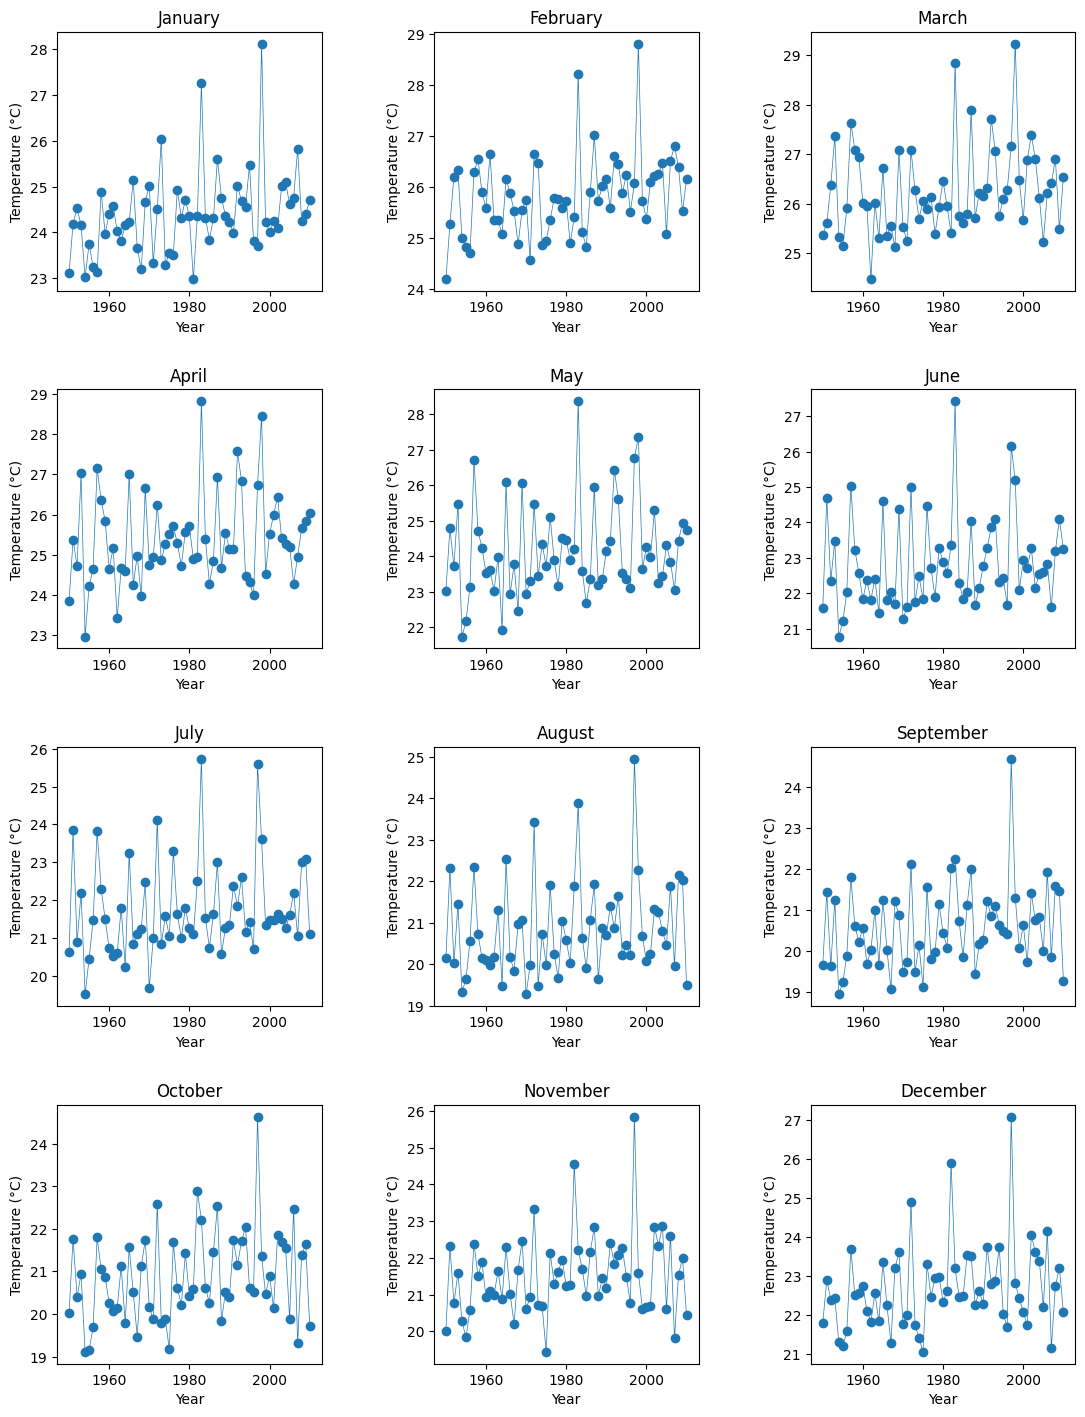

In [6]:
def visualize(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns 1 figure with 12 subplots by month of an average sea surface temperature
    vs year from el Niño data set.
    """

    # Setting up arrays of months and years of the data
    month = 1
    months = [ "December", "January", "February", "March", "April", "May", "June", "July",
              "August", "September", "October", "November"]
    years = df["YEAR"].values.reshape(-1).astype(int)


    fig, axs = plt.subplots(4, 3, figsize=(12, 15))
    fig.tight_layout(pad=5.0)

    for i in range(4):
      for j in range(3):
        ax = axs[i, j]
        # Create a plot by month using the modulo function to broadcast by month
        # The y arange generates the corrected index of each record (i.e. start
        # from 1 and ending to 12)
        if month == 12:
          month = 0
        ax.plot(years, y[np.arange(1, len(y)+1, 1)%12==month], linewidth = 0.5, marker = 'o')
        ax.set_title('{}'.format(months[month]))
        ax.set_xlabel('Year')
        ax.set_ylabel('Temperature (°C)')
        month += 1

visualize(df)

### Fig. 1. Average sea surface temperature in degrees Celcius vs year per month from El Niño - Sea Surface Temperatures data set recorded from 1950 to 2010. A visual examination shows that the temperature has risen slightly every from 1950 to 2010.

# 2. Gaussian Process Regression (GPR)

In [7]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """
    # YOUR CODE HERE
    inter_time = []
    for month in range(1, 973): # There are 972 months between January 1950 and December 2030
      if month%12== 2:
        if ((month-2)/12+1950)%4==0: # Accounting for leap years
          for day in range(1,30): inter_time.append(month + day/100) # Leap years
        else:
          for day in range(1,29): inter_time.append(month + day/100) # Regular years
      elif month%12== 4 or month%12== 6 or month%12== 9 or month%12== 11:
        for day in range(1,31): inter_time.append(month + day/100) # Months with 30 days
      else:
        for day in range(1,32): inter_time.append(month + day/100) # Months with 31 days

    # Removing days after December 1st
    inter_time = inter_time[:len(inter_time)-30]
    return inter_time

t = get_interpolated_time()

OrderedDict([('mean:value', 23.09262295081967), ('kernel:k1:log_constant', 1.6168480842330673), ('kernel:k2:metric:log_M_0_0', 5.0106352940962555)])


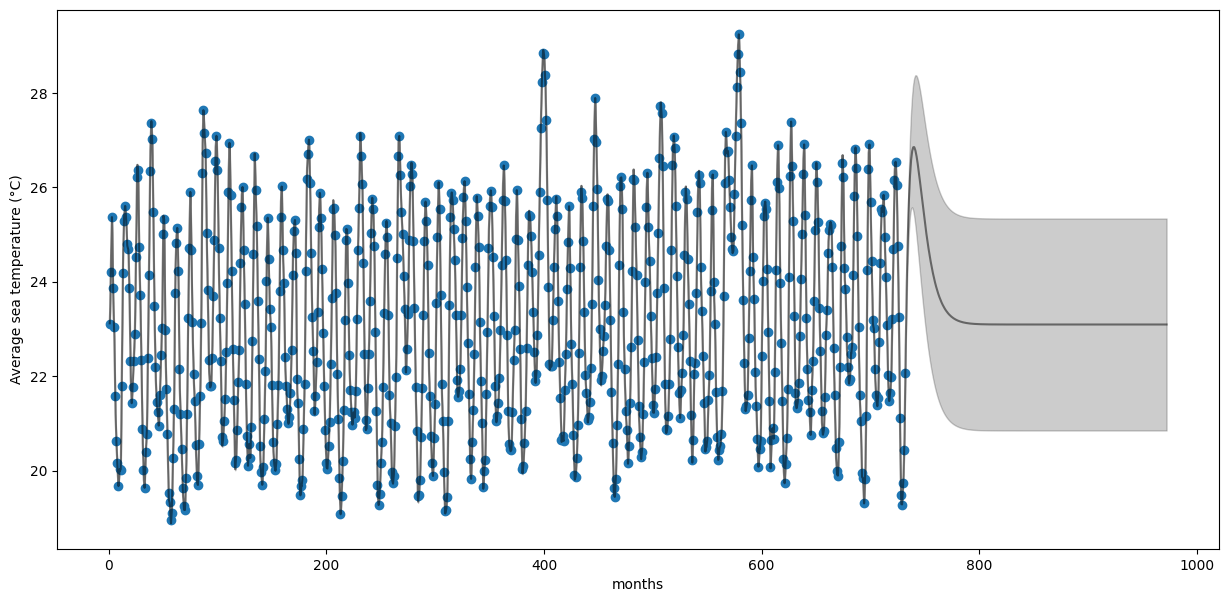

In [87]:
def gaussian_process_regression(time, data, interp_time, initial_guess):

    """
    Perform Gaussian Process Regression (GPR) using the George package to model sea surface temperatures.

    This function implements GPR on the given data to predict sea surface temperatures at different time points.
    It also visualizes the results, including predictions with uncertainties.

    Parameters
    ----------
    time : array-like
        An array of shape (732,) containing time values between 1950 and 2010, sampled every month.
    data : array-like
        An array of shape (732,) containing sea surface temperatures for each month between 1950 and 2010.
    interp_time : array-like
        An array of shape (29555,) containing time values between 1950 and 2030, sampled every day for prediction.
    initial_guess : array-like or float
        The initial guess for the Gaussian Process model. The number of parameters depends on the chosen kernel.

    Returns
    -------
    gp : George GP
        A trained Gaussian Process model (George GP) with updated hyperparameters following GPR.

    Visualization:
    - A plot of predicted sea surface temperatures with uncertainties.
    - A scatter plot of the training data points.
    - x-axis labeled as "months."
    - y-axis labeled as "Average sea temperature (°C)."

    Example Usage:
    gp = gaussian_process_regression(x, y, t, initial_guess)
    """

    # YOUR CODE HERE
    plt.figure(figsize=(15,7))
    kernel = np.var(data) * kernels.Matern32Kernel(initial_guess)
    # kernel = np.var(data) * kernels.ExpSquaredKernel(initial_guess)
    gp = george.GP(kernel, mean=np.mean(data), fit_mean=True)
    gp.compute(time)

    pred, pred_var = gp.predict(data, interp_time, return_var=True)

    print(gp.get_parameter_dict())

    plt.fill_between(interp_time, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                    color="k", alpha=0.2)
    plt.plot(interp_time, pred, "k", lw=1.5, alpha=0.5)
    plt.scatter(time, data)
    plt.xlabel("months")
    # plt.xlim(0, 100)
    # plt.ylim(16, 30)
    plt.ylabel("Average sea temperature (°C)");

    return gp

initial_guess = 150
test = gaussian_process_regression(x, y, t, initial_guess)

### Fig. 2. Average sea surface temperature in degrees Celcius vs months from El Niño - Sea Surface Temperatures data set recorded monthly from 1950 to 2010 and a Gaussian processing model fit using a Matern32Kernel for interpolation for each day between January 1st, 1950 and December 1st, 2050. The model with an initial guess of 150 predicts a rise in the temperature and then a decrease over the year until it reaches the average temperature of the previous years.

###### In English this means that the model predicts that by 2030(ish) we humans will have messed up everything real bad and then died becasue of course there's no more water and then the Earth settles back to good life :) But all is well...

# 3. Optimize

In [88]:
def optimize(gp):
    """
    Optimize the hyperparameters of a Gaussian Process (GP) model using a chosen optimization method.

    This function searches for the optimal set of hyperparameters for the GP model to improve its performance.
    The results of the optimization are printed, and the GP model is updated with the optimized hyperparameters.

    Parameters
    ----------
    gp : George GP
        A Gaussian Process model (George GP) with initial hyperparameters.

    Returns
    -------
    gp : George GP
        A Gaussian Process model with updated hyperparameters following optimization.

    Optimization Details:
    - The negative log-likelihood and its gradient are defined based on the GP model and data.
    - The chosen optimization method (e.g., minimize) is used to find the hyperparameters that maximize the log-likelihood.
    - The results of the optimization, including the optimized hyperparameters, are printed.

    Example Usage:
    gp = optimize(gp)
    """

    def neg_ln_like(p):
      gp.set_parameter_vector(p)
      return -gp.log_likelihood(y)

    def grad_neg_ln_like(p):
      gp.set_parameter_vector(p)
      return -gp.grad_log_likelihood(y)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    print(result)
    gp.set_parameter_vector(result.x)
    return gp

test = optimize(test)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 775.3541135412648
        x: [ 2.309e+01  2.118e+00  3.139e+00]
      nit: 13
      jac: [-2.111e-08 -6.602e-07  5.615e-07]
 hess_inv: [[ 1.243e-01  1.751e-04  1.091e-04]
            [ 1.751e-04  2.363e-02  1.789e-02]
            [ 1.091e-04  1.789e-02  1.531e-02]]
     nfev: 18
     njev: 18


# 4. Visualize your model

OrderedDict([('mean:value', 23.094560546748962), ('kernel:k1:log_constant', 2.1176106063685536), ('kernel:k2:metric:log_M_0_0', 3.138584179078962)])


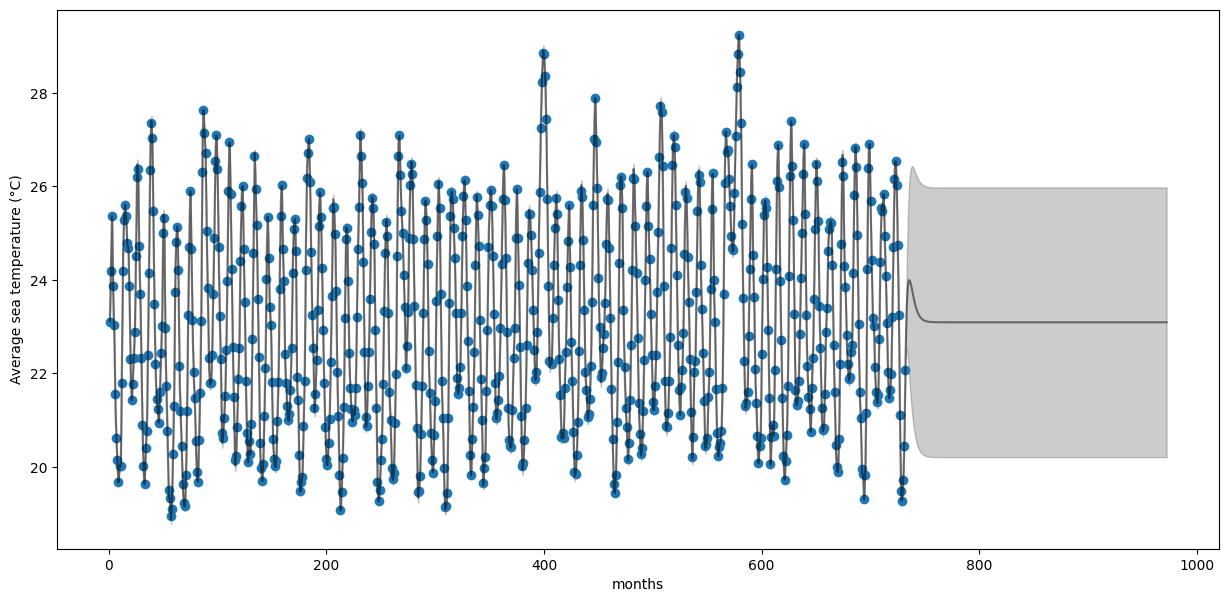

In [90]:
def visualize_model(time, data, interp_time, gp):

    """
    Visualize the Gaussian Process Regression (GPR) model and its predictions.

    This function generates plots to visualize the GPR model's predictions and uncertainties.
    It also comments on the model's effectiveness in predicting temperatures beyond 2010.

    Parameters
    ----------
    time : array-like
        An array of shape (n,) containing the time values of the training data.
    data : array-like
        An array of shape (n,) containing the corresponding sea surface temperature data.
    interp_time : array-like
        An array of shape (m,) containing the time values for which predictions are made.
    gp : George GP
        A trained Gaussian Process model (George GP) for making predictions.

    Returns
    -------
    None

    Plots:
    - Predicted values with uncertainties.
    - Scatter plot of training data points.
    - x-axis labeled as "months."
    - y-axis labeled as "Average sea temperature (°C)."
    - Fill between predictions with uncertainties.
    - Solid line representing the predicted values.

    Figure Caption:
    - Comment on the effectiveness of the GPR model in predicting temperatures beyond 2010.

    Example Usage:
    visualize_model(x, y, t, test)
    """

    plt.figure(figsize=(15,7))
    pred, pred_var = test.predict(data, interp_time, return_var=True)
    print(gp.get_parameter_dict())

    plt.fill_between(interp_time, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                    color="k", alpha=0.2)
    plt.plot(interp_time, pred, "k", lw=1.5, alpha=0.5)
    plt.scatter(time, data)
    plt.xlabel("months")
    # plt.xlim(0, 100)
    # plt.ylim(16, 30)
    plt.ylabel("Average sea temperature (°C)")

visualize_model(x, y, t, test)

### Fig. 3. Average sea surface temperature in degrees Celcius vs months from El Niño - Sea Surface Temperatures data set recorded monthly from 1950 to 2010 and an optimized Gaussian processing model fit using a Matern32Kernel for interpolation for each day between January 1st, 1950 and December 1st, 2050. The optimized model predicts a slight rise in the temperature and then a decrease and settle over the average temperature.